# Determining the cost of cars

## Purpose of the study and work plan

**Task**  

A used car service is developing an app to attract new customers. In it, you can quickly find out the market value of your car. We have historical data at our disposal: technical characteristics, configurations and prices of cars. You need to build a model to determine the cost.  

The customer is important:  

- quality of prediction;  
- prediction speed;  
- studying time.  

**Data**  

*Features*  
- DateCrawled - date of downloading the profile from the database  
- VehicleType - type of car body  
- RegistrationYear — year of car registration  
- Gearbox - type of gearbox  
- Power - power (hp)  
- Model - car model  
- Kilometer - mileage (km)  
- RegistrationMonth — month of car registration  
- FuelType — type of fuel  
- Brand - car brand  
- Repaired - was the car under repair or not  
- DateCreated — date of creation of the questionnaire  
- NumberOfPictures - the number of photos of the car  
- PostalCode - postal code of the owner of the profile (user)  
- LastSeen - date of last user activity  

*Target feature*  
- Price — price (euro)  

**Work plan**

1) Loading data.  
2) Review and data preprocessing: fill in the missing values and process the anomalies in the columns. If among the signs there are non-informative ones, we will remove them.  
3) Preparation of a sample for training models.  
4) Training of different models, one of which is LightGBM, at least one is not boosting. For each model, let's try different hyperparameters.  
5) Let's analyze the training time, the prediction time and the quality of the models.  
6) Based on the criteria of the customer, we will choose the best model and check its quality on a test sample.

## Data preprocessing

### Data overview

We import the necessary libraries for the study.

In [1]:
import numpy as np
import pandas as pd
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

Let's download and examine the data.

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.shape

(354369, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


**Conclusion:**  
1) In dataframe 354369 object, 15 features and target feature 'price'.  
2) It is required to convert the names of all columns to lowercase and "snake" format.  
3) Requires data type change in some columns.  
4) There are gaps in some columns. Passes need to be processed.  
5) It is necessary to check the feature values for duplicates and anomalies.  
6) There are categorical features in the data. They need to be coded.  
7) Significant features that affect the cost of the car include the following columns:  
- VehicleType — vehicle body type;  
- RegistrationYear - the age of the car in years affects the cost;  
- Gearbox - type of gearbox;  
- Power - power (hp);  
- Model — car model;  
- Kilometer — mileage (km);  
- FuelType — type of fuel;  
- Brand — car brand;  
- Repaired - was the car under repair or not.  

8) It is necessary to remove non-informative features and examine the sample for multicollinearity of features.  

### Changing column names

Feature names are incorrect. Let's bring the names of all columns to lowercase and "snake" format.

In [6]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Data type conversion

Convert the data type of the `date_crawled`, `date_created` and `last_seen` columns from *object* to *datetime*

In [7]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df[['date_crawled', 'date_created', 'last_seen']].dtypes

date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object

### Gaps handling

We visualize the number of gaps in the columns.

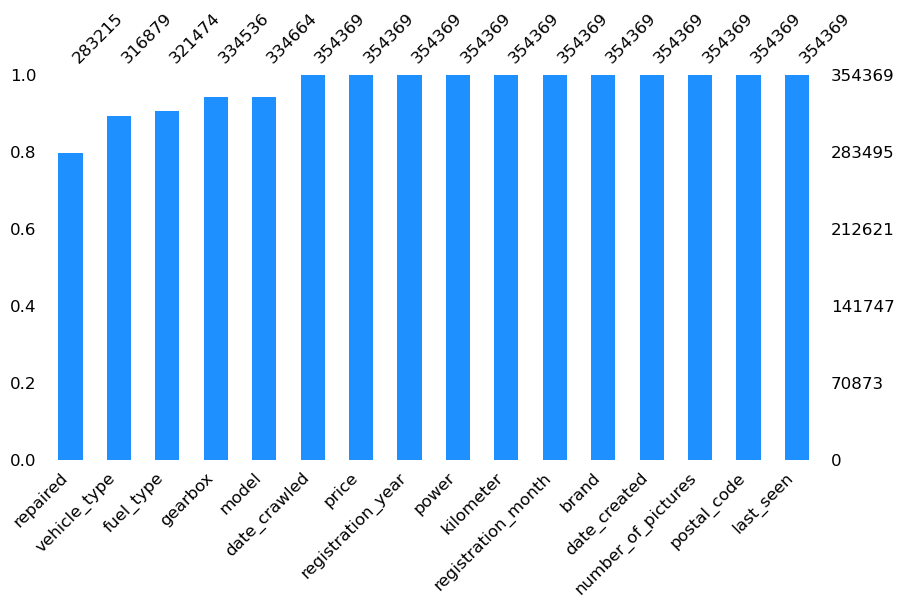

In [8]:
missingno.bar(df, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Omissions are present in the features `repaired`, `vehicle_type`, `fuel_type`, `gearbox`, `model` important for model training.

- Column `repaired`

In [9]:
df['repaired'].isna().sum() / len(df)

0.20079070121822168

The `repaired` column is missing 20% of the data - that's significant.

In [10]:
df['repaired'].value_counts(normalize=True)

no     0.872697
yes    0.127303
Name: repaired, dtype: float64

In 87% of objects, the `repaired` column is filled with the value `no`. Let's fill in the gaps with the most common `no` value, since there is no way to reliably recover the missing information based on other object parameters.

In [11]:
df['repaired'] = df['repaired'].fillna('no')

- Columns `vehicle_type`, `fuel_type`, `gearbox`, `model`.

Since the `brand` column has no gaps, fill in the missing values of the `vehicle_type`, `fuel_type`, `gearbox`, `model` columns with the most frequently occurring brand value. Before filling, we will display the lines with gaps to check the result after filling.

In [12]:
features_with_na = ['vehicle_type', 'fuel_type', 'gearbox', 'model'] # missing feature list
missing_values_examples = df.loc[df.isna().any(axis=1), features_with_na].head()
missing_values_examples

,vehicle_type,fuel_type,gearbox,model
0,NaN,petrol,manual,golf
1,coupe,gasoline,manual,NaN
9,small,NaN,manual,golf
13,wagon,NaN,manual,passat
15,small,petrol,NaN,ka


In [13]:
for feature in features_with_na:
    #for each feature, we create a pivot table with the number of each feature value for each brand
    feature_by_brand = df.pivot_table(index='brand', columns=feature, values='price', aggfunc='count')
    #for each brand, select dataframe rows by attribute and fill in the missing values with the most frequent attribute value by brand
    for brand in feature_by_brand.index:
        df.loc[df['brand'] == brand, feature] = df.loc[df['brand'] == brand, feature].fillna(feature_by_brand.loc[brand].idxmax())

Let's look at the result of filling in the gaps.

In [14]:
df.loc[missing_values_examples.index, features_with_na]

,vehicle_type,fuel_type,gearbox,model
0,sedan,petrol,manual,golf
1,coupe,gasoline,manual,a4
9,small,petrol,manual,golf
13,wagon,petrol,manual,passat
15,small,petrol,manual,ka


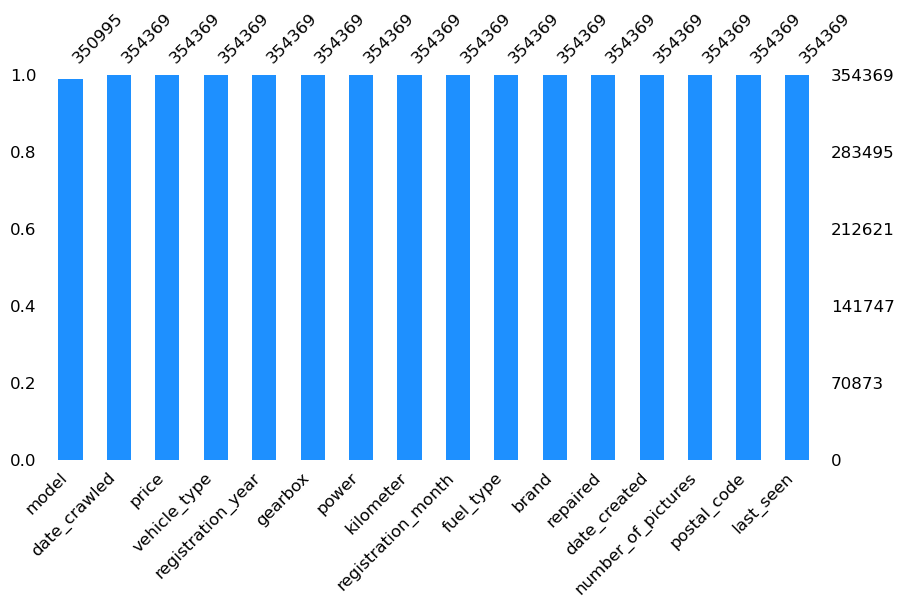

In [15]:
missingno.bar(df, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

The `model` column has empty values. Let's get rid of these lines with gaps.

In [16]:
df = df.dropna()
df.shape

(350995, 16)

**Conclusion:**
1) The gaps in the `repaired` column were filled with the most common value `no` ;  
2) The gaps in the `vehicle_type`, `fuel_type`, `gearbox`, `model` columns were filled in with the most frequently occurring brand value.  
3) 3374 rows with gaps in the `model` column that could not be filled were removed.

### Duplicate handling

Check the dataframe for duplicate rows.

In [17]:
print(f'The table has {df.duplicated().sum()} duplicate rows.')

The table has 5 duplicate rows.


Remove duplicate lines.

In [18]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'The table has {df.duplicated().sum()} duplicate rows.')

The table has 0 duplicate rows.


In [19]:
df.shape

(350990, 16)

Let's check the categorical features for the presence of explicit and implicit duplicates.

In [20]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for cat_feature in cat_features:
    print(f'Unique values of feature {cat_feature}:')
    print(sorted(df[cat_feature].astype('str').unique()))
    print()

Unique values of feature vehicle_type:
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

Unique values of feature gearbox:
['auto', 'manual']

Unique values of feature model:
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'de

There is an implicit duplicate in the `fuel_type` column: the values gasoline and petrol are the same. Let's replace all petrol values with gasoline.

In [21]:
df['fuel_type'] = df['fuel_type'].replace(to_replace='petrol', value='gasoline')
sorted(df['fuel_type'].unique())

['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other']

**Conclusion:**  
1) Removed 5 duplicate rows from the table;  
2) implicit duplicates were found and fixed in the `fuel_type` column.

### Handling anomalous values

- Column `price`

In [22]:
df['price'].describe()

count    350990.000000
mean       4410.797533
std        4503.346994
min           0.000000
25%        1099.000000
50%        2700.000000
75%        6399.000000
max       20000.000000
Name: price, dtype: float64

In the `price` column, the mean is shifted upwards relative to the median, which means there are anomalous outliers. We also see that the minimum price value is 0, which is also an anomaly.

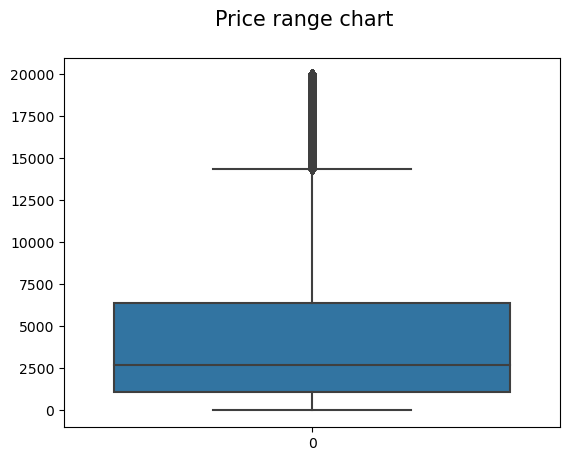

In [23]:
sns.boxplot(data=df['price'])
plt.suptitle('Price range chart', fontsize=15);

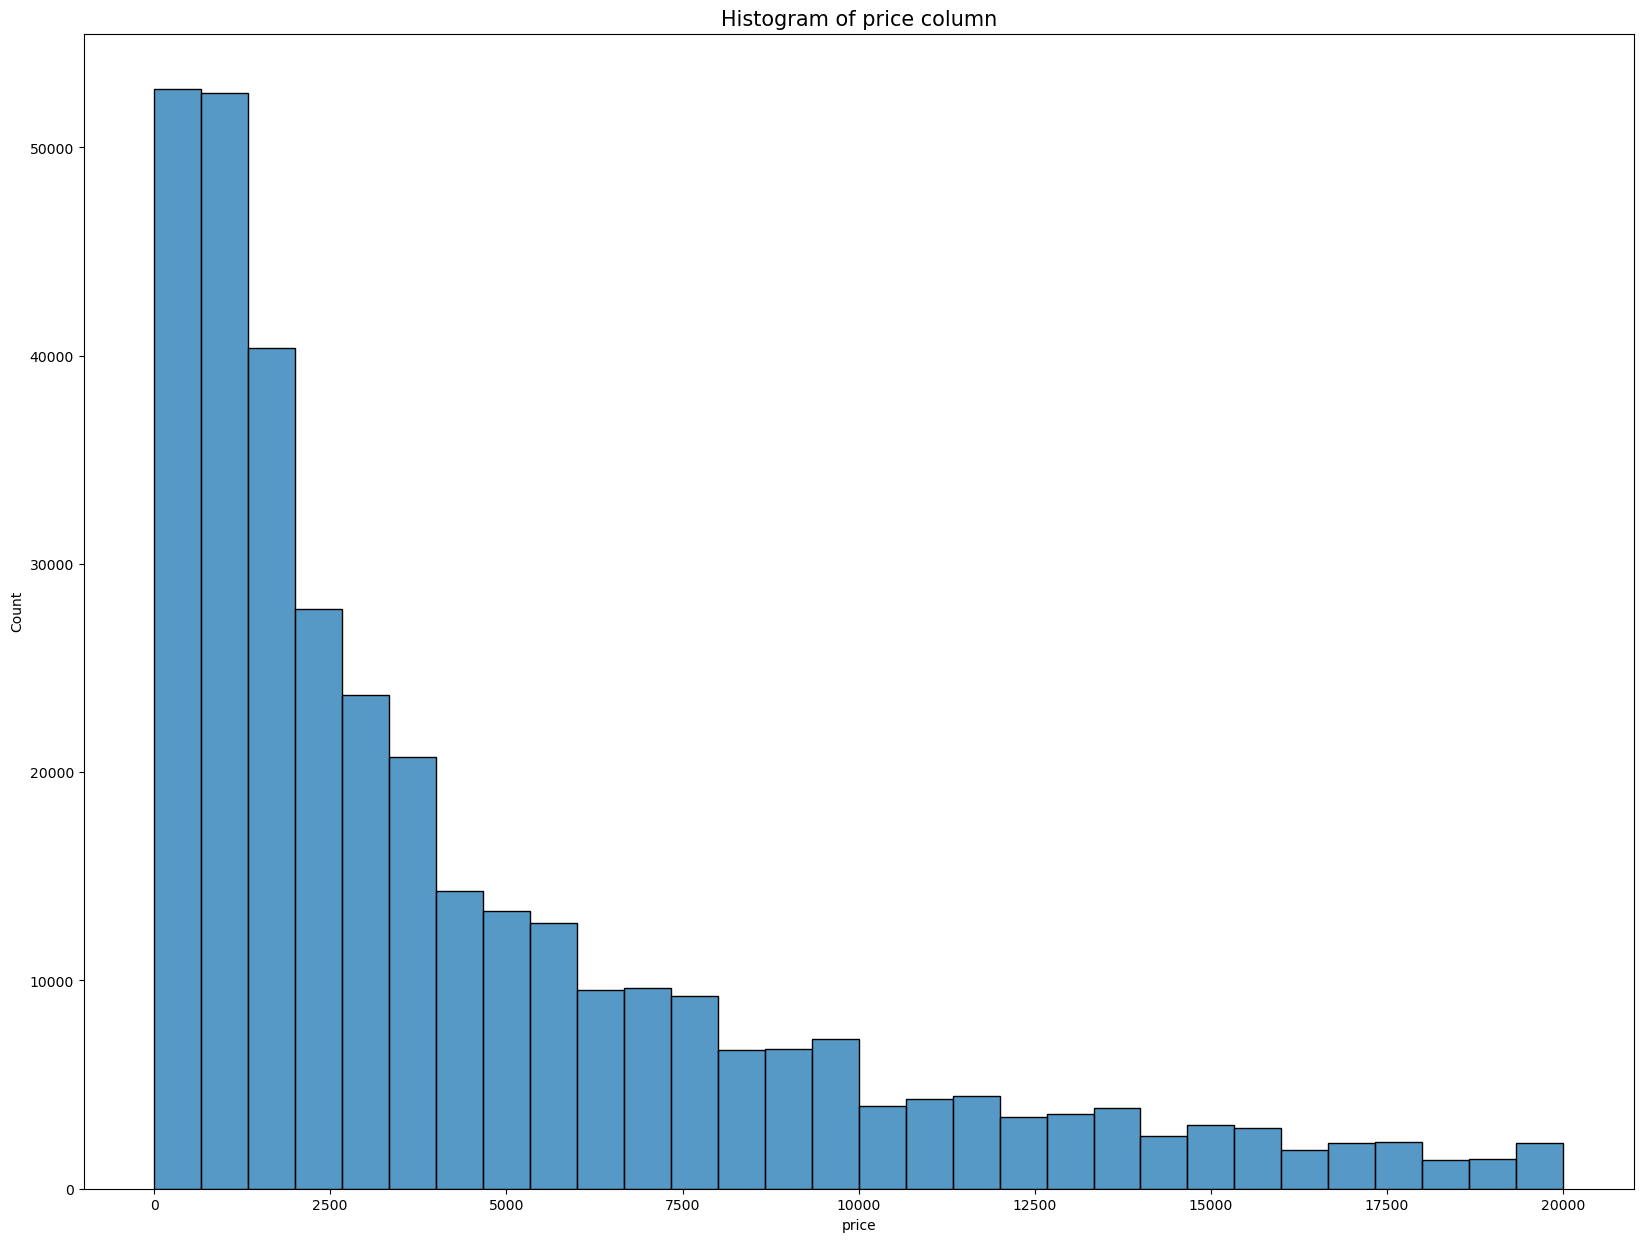

In [24]:
plt.figure(figsize=(20,15))
plt.title('Histogram of price column', fontsize=15);
sns.histplot(data=df['price'], bins=30);

Let us select such quantiles of the distribution of price values in order to cut off anomalous values and outliers.

In [25]:
def check_price_quantiles(q_lower, q_upper):
    """
    The function takes the values of the upper and lower quantile and displays their values, filters the dataset,
    clipping values below the lower and above the upper quantile, displays a range plot and characteristic values
    the resulting dataset.
    """
    price_quantiles = df['price'].quantile([q_lower, q_upper])
    print(price_quantiles)
    print()
    df_filtered = df.loc[(df['price'] >= price_quantiles.loc[q_lower]) & (df['price'] <= price_quantiles.loc[q_upper])]
    sns.boxplot(data=df_filtered['price'])
    plt.suptitle('Price range chart', fontsize=15);
    print(df_filtered['price'].describe())

Let's look at the 5% and 95% quantiles.

0.05      200.0
0.95    14500.0
Name: price, dtype: float64

count    316713.000000
mean       3943.483346
std        3504.649888
min         200.000000
25%        1200.000000
50%        2700.000000
75%        5850.000000
max       14500.000000
Name: price, dtype: float64


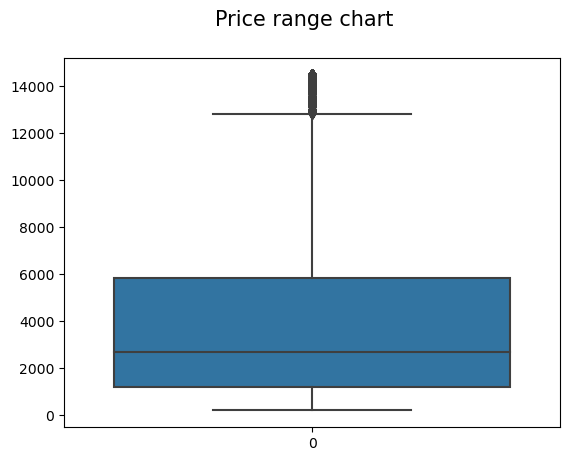

In [26]:
check_price_quantiles(.05, .95)

The lower price limit of 200 euros seems adequate. The upper limit is 14,600 euros. The mean is still heavily skewed up. We choose such an upper bound to get rid of outliers in the distribution.

0.05      200.0
0.90    11400.0
Name: price, dtype: float64

count    299228.000000
mean       3420.435437
std        2827.579207
min         200.000000
25%        1150.000000
50%        2500.000000
75%        5000.000000
max       11400.000000
Name: price, dtype: float64


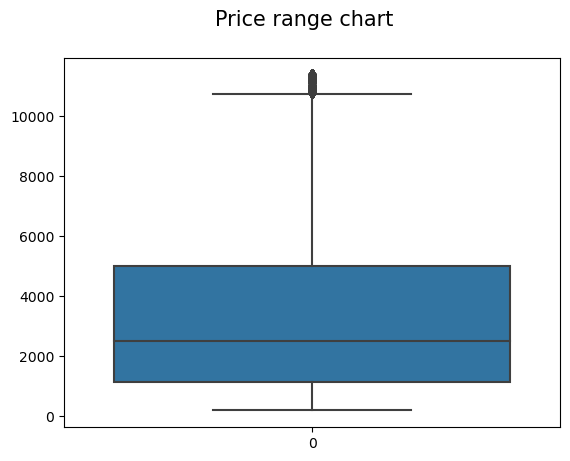

In [27]:
check_price_quantiles(.05, .90)

0.05     200.0
0.85    9000.0
Name: price, dtype: float64

count    282137.000000
mean       3011.710747
std        2352.044128
min         200.000000
25%        1050.000000
50%        2300.000000
75%        4500.000000
max        9000.000000
Name: price, dtype: float64


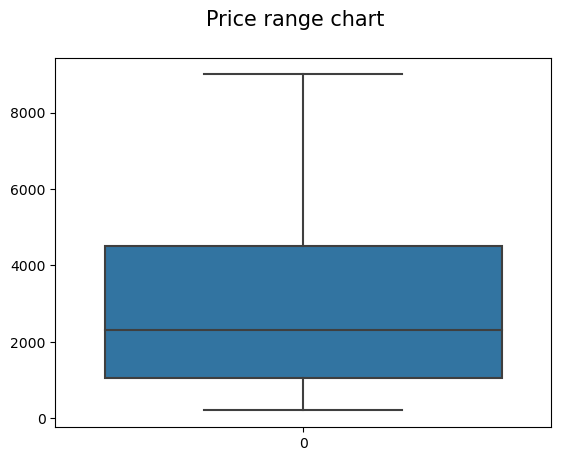

In [28]:
check_price_quantiles(.05, .85)

With an upper limit of 9,000 euros, distribution got rid of emissions. Let's filter our dataframe by the price value for the 5% and 85% quantiles.

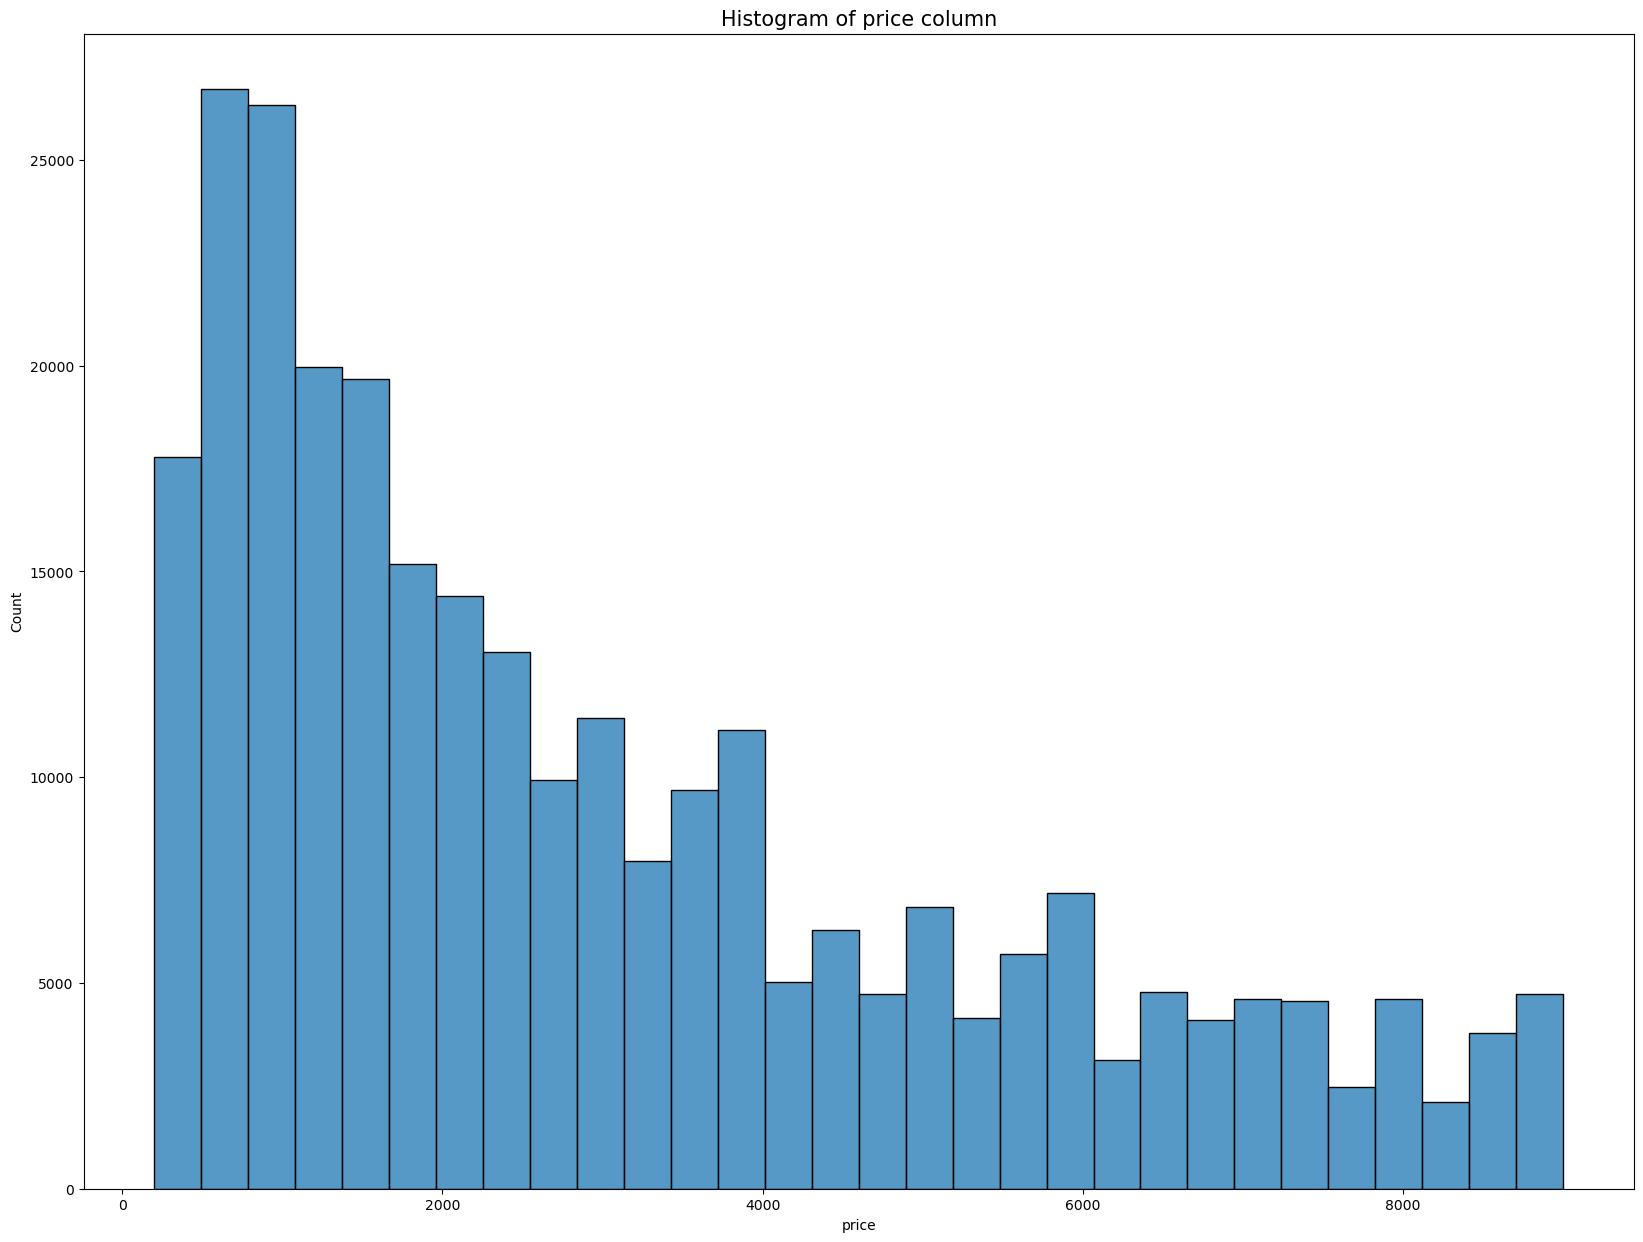

In [29]:
df = df.loc[(df['price'] >= df['price'].quantile([.05, .85]).loc[0.05]) & 
            (df['price'] <= df['price'].quantile([.05, .85]).loc[0.85])]
plt.figure(figsize=(20,15))
plt.title('Histogram of price column', fontsize=15);
sns.histplot(data=df['price'], bins=30);

In [30]:
df.shape

(282137, 16)

- Column `registration_year`

Let's see for which years there are ads in the data by the `date_created` column.

In [31]:
pd.DatetimeIndex(df['date_created']).year.value_counts()

2016    282119
2015        17
2014         1
Name: date_created, dtype: int64

Let's look at the characteristic values of the `registration_year` column.

In [32]:
df['registration_year'].describe()

count    282137.000000
mean       2002.935492
std          58.163315
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: registration_year, dtype: float64

In [33]:
sorted(df['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1928,
 1930,
 1931,
 1932,
 1934,
 1936,
 1937,
 1938,
 1942,
 1943,
 1945,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2800,
 2900,
 3000,
 3700,
 4000,
 4500,
 5000,
 5555,
 5900,
 5911,
 6000,
 7100,
 8200,
 8500,
 9000,
 9999]

We see that the `registration_year` column has many incorrect values for the year of registration. Let's look at the latest date of registration of the announcement.

In [34]:
df['date_created'].max()

Timestamp('2016-04-07 00:00:00')

The date of registration of the car cannot be later than the date of creation of the questionnaire. Let's filter the dataset by the values of the year of registration from 1910 to 04.2016 and look at the resulting distribution of the values of the `registration_year` column.

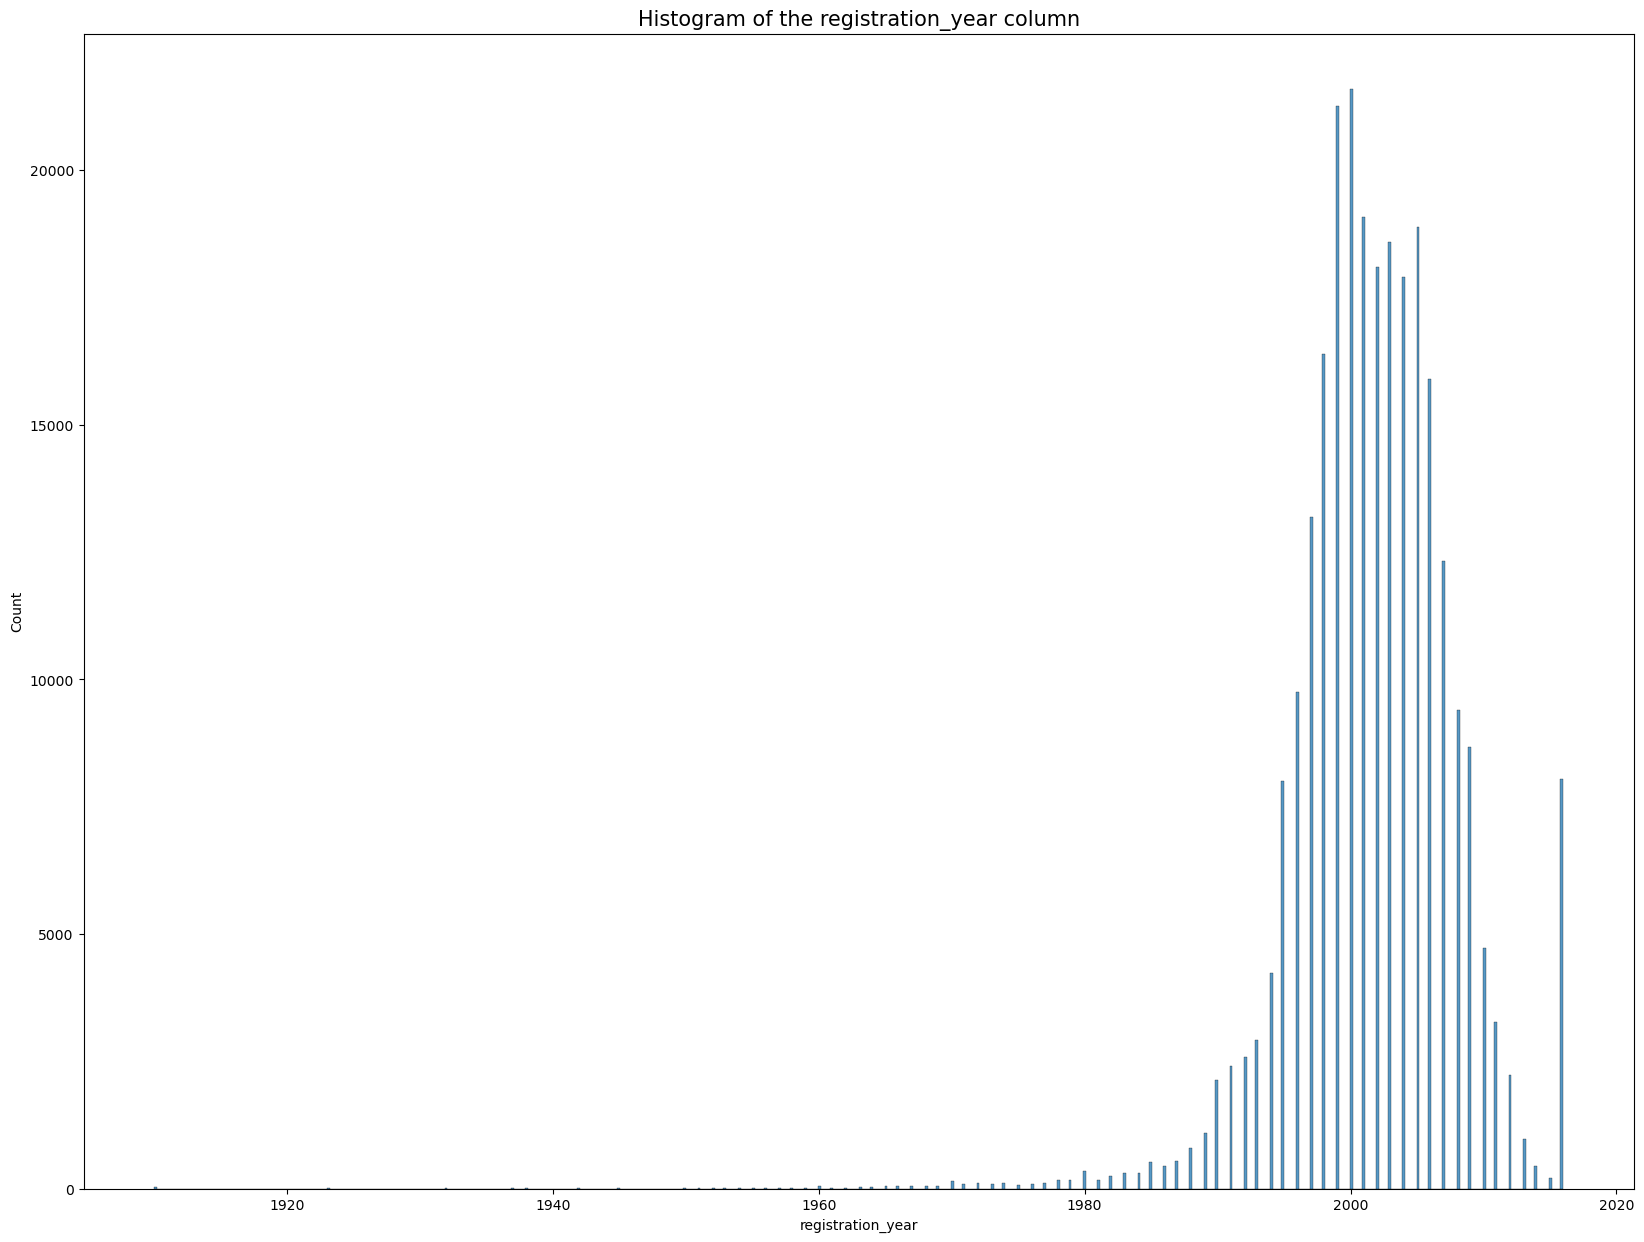

In [35]:
df = df.loc[(df['registration_year'] >= 1910) & (df['registration_year'] < 2017)]
plt.figure(figsize=(20,15))
plt.title('Histogram of the registration_year column', fontsize=15);
sns.histplot(data=df['registration_year']);

We cut off all objects older than 1960.

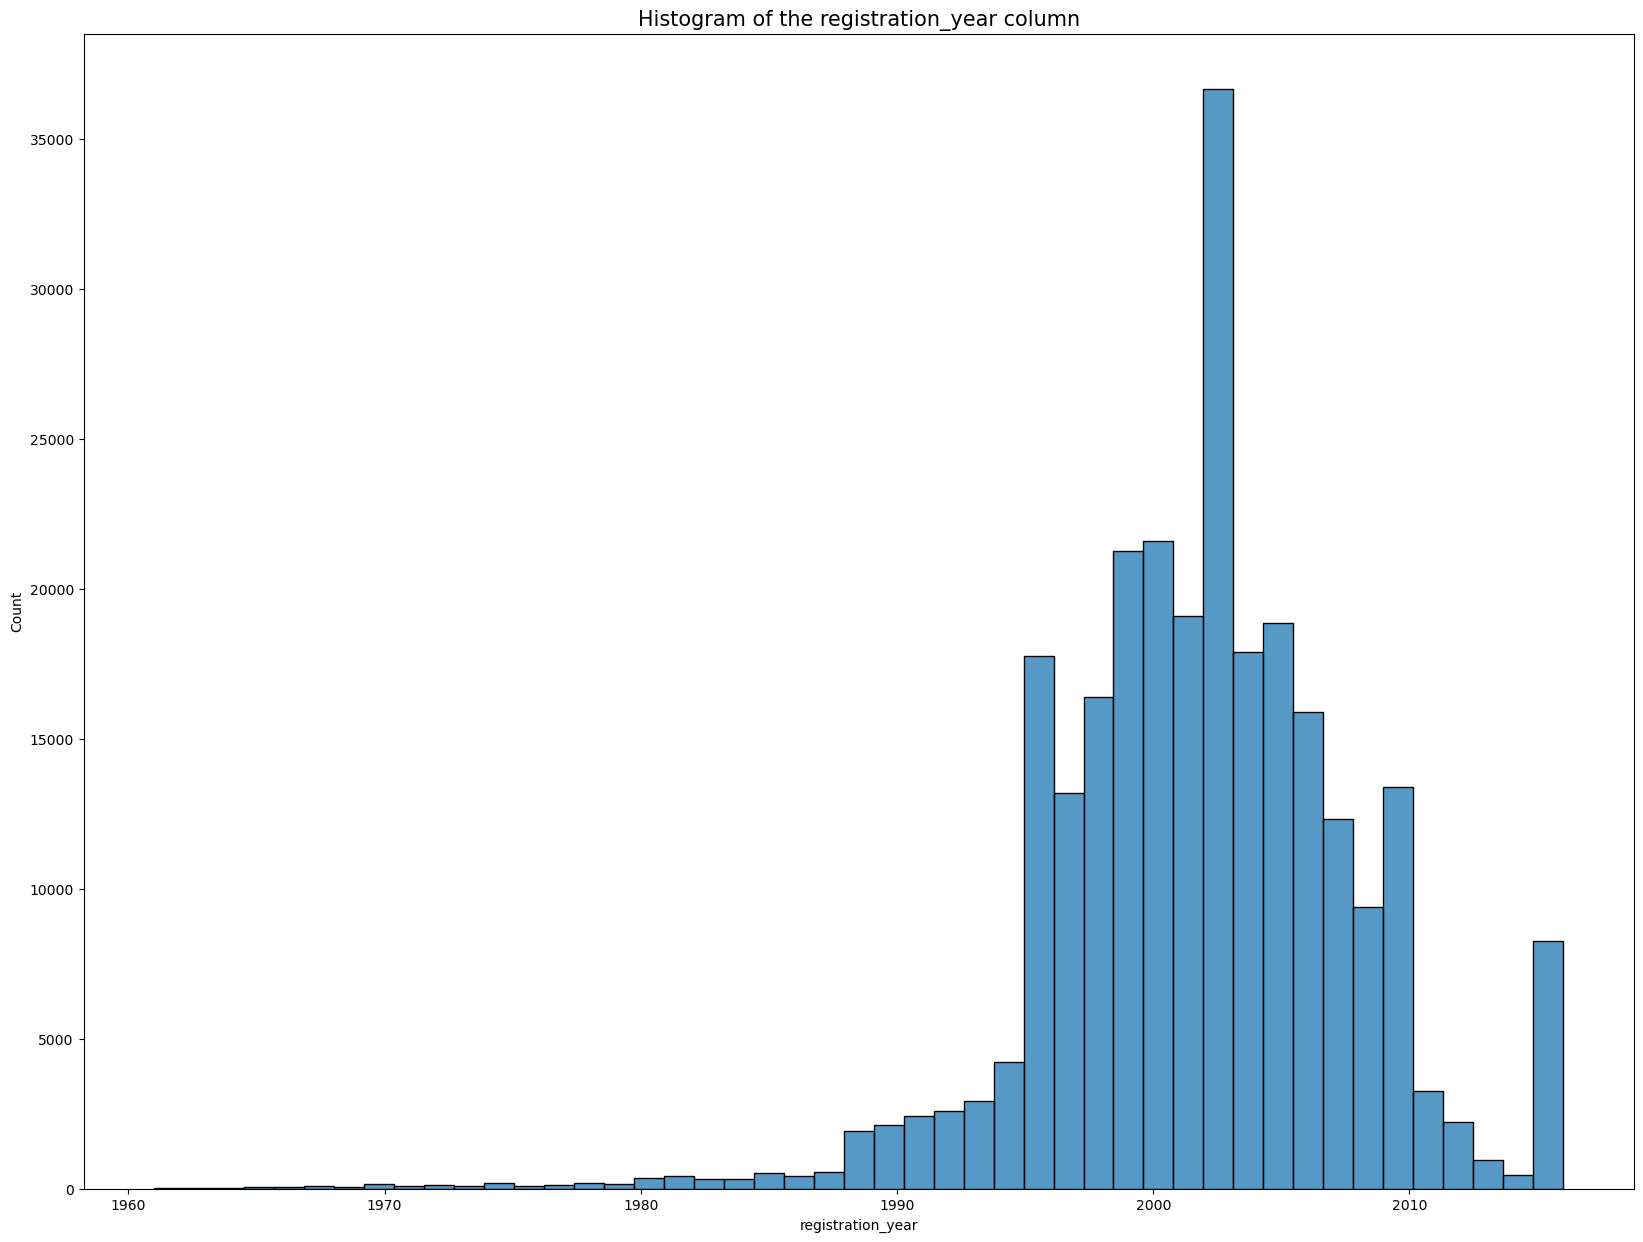

In [36]:
df = df.loc[df['registration_year'] > 1960]
plt.figure(figsize=(20,15))
plt.title('Histogram of the registration_year column', fontsize=15);
sns.histplot(data=df['registration_year'], bins=47);

In [37]:
df.shape

(269453, 16)

- Column `kilometer`

In [38]:
df['kilometer'].describe()

count    269453.000000
mean     133561.363206
std       32690.244665
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

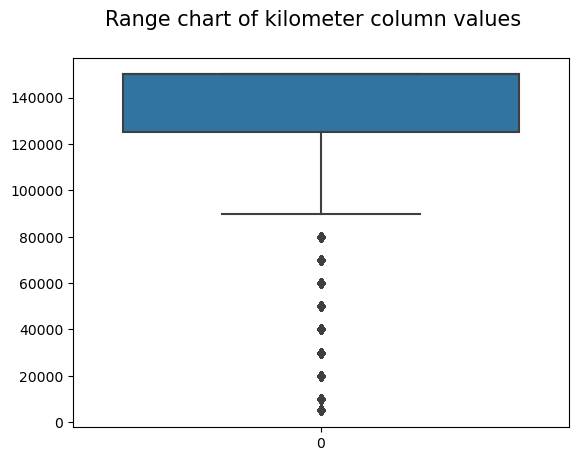

In [39]:
sns.boxplot(data=df['kilometer'])
plt.suptitle('Range chart of kilometer column values', fontsize=15);

We see that most of the objects have mileage of 150000. There are single outliers of values less than 90000, but they are few and these are adequate values.

- Column `power`

In [40]:
df['power'].describe()

count    269453.000000
mean        102.994210
std         176.749685
min           0.000000
25%          67.000000
50%         101.000000
75%         136.000000
max       20000.000000
Name: power, dtype: float64

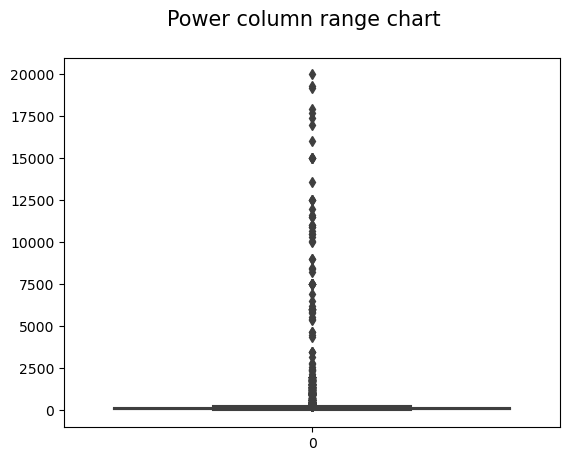

In [41]:
sns.boxplot(data=df['power'])
plt.suptitle('Power column range chart', fontsize=15);

In [42]:
df['power'].value_counts()

0       27888
75      21315
60      14028
101     12055
150     11829
        ...  
700         1
7515        1
2461        1
6006        1
3           1
Name: power, Length: 589, dtype: int64

The column contains a large number of 0 values and abnormally large engine power values. Objects with a null value will have to be removed from the dataset. Let's look at values greater than 1000. Perhaps the owner in the questionnaire attributed an extra zero or did not put a period in the number.

Let's look at values greater than 1000. Perhaps the owner in the questionnaire attributed an extra zero or did not put a period in the number.

In [43]:
df.query('power > 1000').head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1800,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,gasoline,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
5278,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,gasoline,opel,no,2016-03-29,0,33154,2016-04-06 05:44:36
7589,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,gasoline,volkswagen,no,2016-04-02,0,65830,2016-04-06 11:46:49
7648,2016-04-02 11:48:54,1500,small,2000,manual,1400,civic,150000,0,gasoline,honda,no,2016-04-02,0,21509,2016-04-04 09:15:26
9577,2016-03-14 20:06:19,2599,small,2016,manual,1779,zafira,150000,0,gasoline,opel,no,2016-03-14,0,60326,2016-04-07 09:45:27


Let's take the first object from the list and look at other objects from the dataset that match in the brand, model and vehicle_type fields.

In [44]:
df.query("brand == 'toyota' and model == 'corolla' and vehicle_type == 'small'")

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1076,2016-03-30 07:37:04,1400,small,1989,manual,0,corolla,150000,0,gasoline,toyota,no,2016-03-30,0,73329,2016-04-07 00:15:54
1800,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,gasoline,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
5175,2016-03-15 15:37:04,1000,small,2003,manual,97,corolla,150000,4,gasoline,toyota,yes,2016-03-15,0,60385,2016-04-06 07:16:59
10887,2016-03-27 14:54:10,2500,small,1996,manual,75,corolla,125000,8,gasoline,toyota,no,2016-03-27,0,15738,2016-03-27 14:54:10
18721,2016-03-20 17:52:32,2250,small,2000,manual,110,corolla,100000,12,gasoline,toyota,no,2016-03-20,0,1968,2016-04-07 00:46:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325094,2016-03-12 02:36:54,1400,small,1997,manual,0,corolla,125000,3,gasoline,toyota,no,2016-03-12,0,47441,2016-04-05 20:46:07
340763,2016-03-23 14:47:22,950,small,2000,manual,63,corolla,150000,8,gasoline,toyota,no,2016-03-23,0,18109,2016-04-05 16:44:45
341739,2016-03-15 15:53:57,650,small,1995,manual,0,corolla,5000,0,gasoline,toyota,no,2016-03-15,0,28717,2016-03-17 11:18:44
347769,2016-03-14 19:41:19,4699,small,2006,manual,110,corolla,90000,4,gasoline,toyota,no,2016-03-14,0,57319,2016-03-28 04:46:53


Unfortunately, the anomalous value of engine power 1398 cannot be explained by an error in the digit capacity of the number. Such data will simply be deleted. Let's cut off objects with power < 11 and power > 500 and see the distribution.

In [45]:
df = df.loc[(df['power'] > 10) & (df['power'] <= 500)]

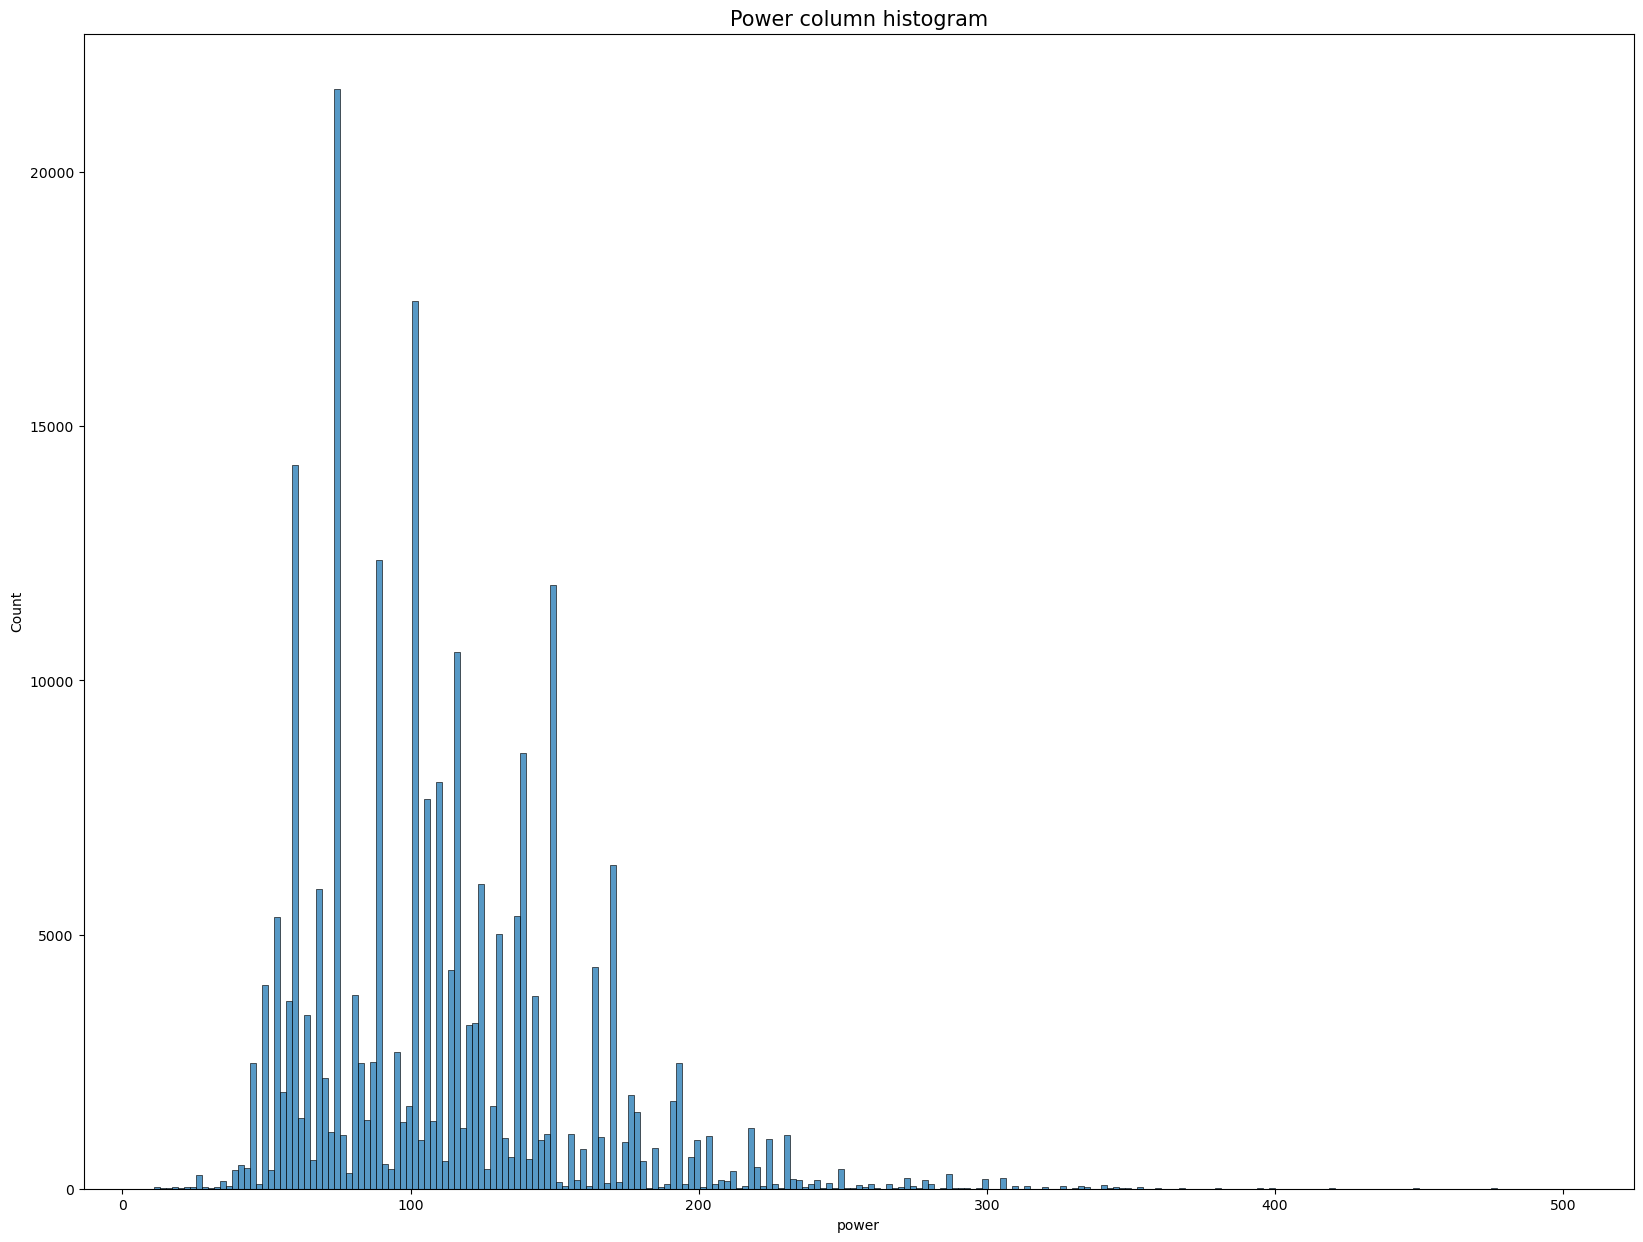

In [46]:
plt.figure(figsize=(20,15))
plt.title('Power column histogram', fontsize=15);
sns.histplot(data=df['power']);

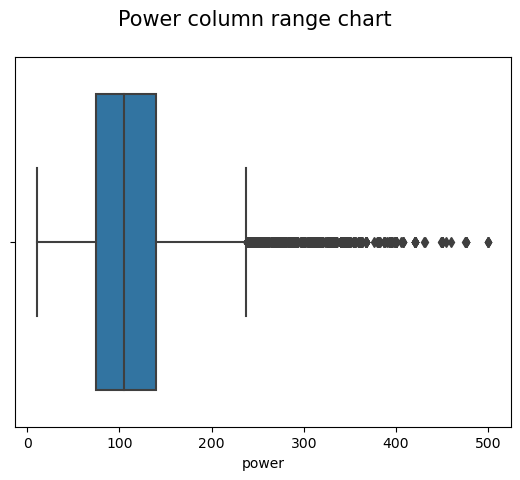

In [47]:
#df.boxplot('power')
sns.boxplot(df['power'])
plt.suptitle('Power column range chart', fontsize=15);

In [48]:
df['power'].describe()

count    241210.000000
mean        111.217002
std          45.768751
min          11.000000
25%          75.000000
50%         105.000000
75%         140.000000
max         500.000000
Name: power, dtype: float64

Let's look at objects with a power of 300 to 500 hp.

In [49]:
df.query('300<=power<=500')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-30,0,33649,2016-04-03 11:44:49
391,2016-04-01 19:49:57,6250,small,2016,manual,310,astra,150000,0,gasoline,opel,no,2016-04-01,0,58809,2016-04-03 16:47:23
444,2016-04-01 22:51:18,8500,sedan,2003,manual,300,a4,150000,3,gasoline,audi,no,2016-04-01,0,18573,2016-04-05 21:45:11
1185,2016-03-26 19:37:50,5800,sedan,2000,auto,326,7er,150000,3,gasoline,bmw,yes,2016-03-26,0,45549,2016-04-02 11:18:22
1235,2016-03-29 15:53:54,4490,coupe,1984,auto,310,other,150000,4,gasoline,porsche,no,2016-03-29,0,85777,2016-03-29 16:41:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349347,2016-03-28 12:38:50,6666,sedan,2002,auto,333,7er,150000,8,gasoline,bmw,no,2016-03-28,0,24534,2016-03-31 20:18:54
349732,2016-03-18 12:47:25,8000,sedan,2002,auto,306,c_klasse,150000,12,gasoline,mercedes_benz,no,2016-03-18,0,78239,2016-04-05 22:16:52
350287,2016-04-04 21:55:50,6995,wagon,2004,auto,306,e_klasse,150000,11,lpg,mercedes_benz,no,2016-04-04,0,42489,2016-04-07 00:45:17
350306,2016-03-28 23:45:59,5800,sedan,2000,auto,326,7er,150000,3,gasoline,bmw,yes,2016-03-28,0,45549,2016-04-07 09:45:20


The data looks plausible. Many models of Mercedez, BMW, Audi brands have engine power up to 500 hp.

In [50]:
df.shape

(241210, 16)

**Conclusion:** as a result of processing anomalous values in the `price`, `registration_year`, `power` columns, 112099 objects were removed from the dataset.

### Features preparation

Remove non-informative features `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`, `last_seen` from the dataset.

In [51]:
df = df.drop(['date_crawled', 'registration_month', 
              'date_created', 'number_of_pictures', 
              'postal_code', 'last_seen'], axis=1)

In [52]:
df.shape

(241210, 10)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241210 entries, 3 to 350989
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              241210 non-null  int64 
 1   vehicle_type       241210 non-null  object
 2   registration_year  241210 non-null  int64 
 3   gearbox            241210 non-null  object
 4   power              241210 non-null  int64 
 5   model              241210 non-null  object
 6   kilometer          241210 non-null  int64 
 7   fuel_type          241210 non-null  object
 8   brand              241210 non-null  object
 9   repaired           241210 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.2+ MB


Let's study the sample for multicollinearity of quantitative features.

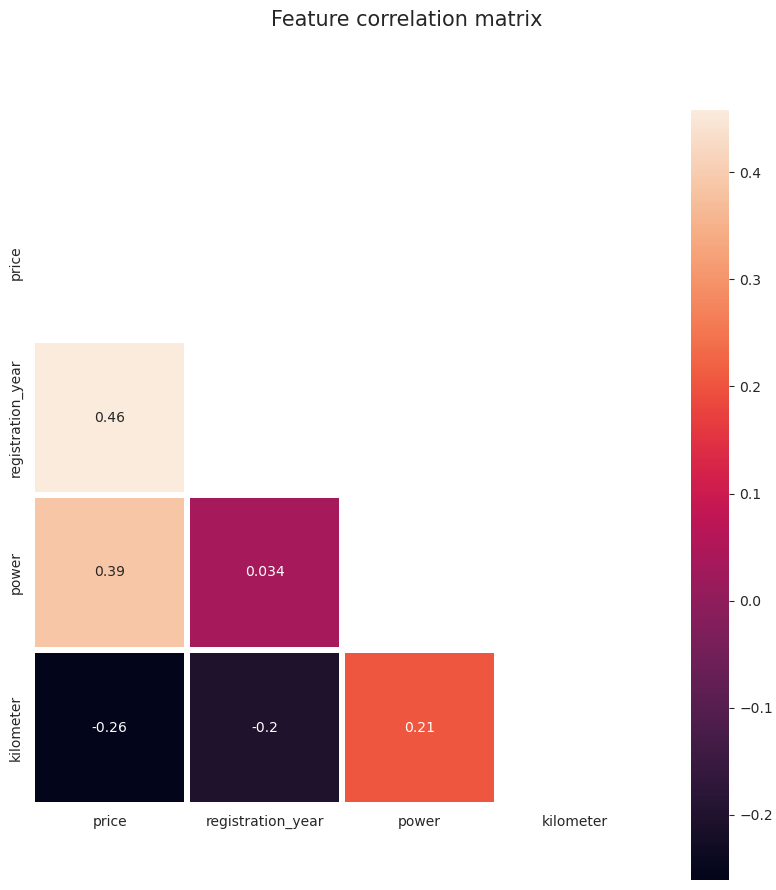

In [54]:
df_corr = df.corr()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    plt.suptitle('Feature correlation matrix', fontsize=15);
    ax = sns.heatmap(df_corr, mask=mask, square=True, annot=True, linewidths=3, linecolor='white')

As you can see, there is no close relationship of signs. The Pearson correlation coefficient for features does not exceed 0.21. It can be noted that there is a weak relationship between features and the target feature `price`. For example, a direct linear relationship between `registration_year` and `price` (the older the year, i.e. the newer the car, the higher the price), `power` and `price`, a negative linear relationship between mileage and price.

In [55]:
df = df.reset_index(drop=True)

We divide the sample into features and the target feature.

In [56]:
features = df.drop('price', axis=1)
target = df['price']

We divide the initial data into training, validation and test sets in the ratio of 60% / 20% / 20%, respectively. We will use the validation sample to analyze the models, and we will check the quality of the best model on the test sample.

In [57]:
features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, random_state=12345)


In [58]:
features_train.shape, features_valid.shape, features_test.shape

((144726, 9), (48242, 9), (48242, 9))

Let's encode categorical features with two different techniques, since the data will be used to train different models:  
1) OHE direct coding for linear regression  
2) OE order coding for decision tree, random forest, LightGBM  
3) categorical data without coding for CatBoost  
<a name="example"></a>

In [59]:
# direct coding technique OHE for linear regression
features_ohe = pd.get_dummies(features, drop_first=True)
features_train_ohe = features_ohe.loc[features_train.index, :]
features_valid_ohe = features_ohe.loc[features_valid.index, :]
features_test_ohe = features_ohe.loc[features_test.index, :]


# OE order coding technique for decision tree, random forest and LightGBM.
encoder = OrdinalEncoder()
categorial_features = features[cat_features]
categorial_features = pd.DataFrame(encoder.fit_transform(categorial_features),
                                   columns=categorial_features.columns, 
                                   index=categorial_features.index)
features_oe = features.copy()
for column in cat_features:
    features_oe[column] = categorial_features[column]
    
features_train_oe = features_oe.loc[features_train.index, :]
features_valid_oe = features_oe.loc[features_valid.index, :]
features_test_oe = features_oe.loc[features_test.index, :]

In [60]:
features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape

((144726, 301), (48242, 301), (48242, 301))

In [61]:
features_train_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
113709,5.0,2004,1.0,85,122.0,125000,2.0,11.0,0.0
116200,5.0,2004,1.0,75,119.0,150000,2.0,30.0,0.0
105648,4.0,1994,0.0,286,19.0,150000,4.0,2.0,0.0
114019,4.0,2003,0.0,145,153.0,125000,2.0,10.0,0.0
21904,7.0,2000,1.0,204,95.0,150000,2.0,20.0,1.0


## Model training

Let's choose the following models for comparison:

1) Linear Regression
2) DecisionTreeRegressor
3) RandomForestRegressor
4) CatBoostRegressor
5) LGBMRegressor

We will fix the training time, the prediction time and the quality of the models with the RMSE metric.

### LinearRegression 

We bring the numerical features to the same scale, train the model and get the quality metric on the validation set.

In [62]:
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [63]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train)

CPU times: total: 7.47 s
Wall time: 4.82 s


LinearRegression()

In [64]:
features_valid_ohe.shape

(48242, 301)

In [65]:
%%time

predict_LR = model.predict(features_valid_ohe)
rmse_LR = mean_squared_error(target_valid, predict_LR) ** 0.5
print(f'RMSE of linear regression model on the validation set: {rmse_LR}')

RMSE of linear regression model on the validation set: 1581.1182551040408
CPU times: total: 125 ms
Wall time: 99.6 ms


### DecisionTreeRegressor 

Let's select the `max_depth` hyperparameter for the DecisionTreeRegressor model.

In [66]:
%%time

best_result = 10000
best_max_depth = 0
for max_depth in range(2, 21):
    model = DecisionTreeRegressor(random_state=12345, max_depth=max_depth)
    model.fit(features_train_oe, target_train)
    predictions_valid = model.predict(features_valid_oe)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_max_depth = max_depth
        best_result = result
print(f'RMSE of the best model on the validation set: {best_result}')
print(f'max_depth: {best_max_depth}')

RMSE of the best model on the validation set: 1146.8093495853225
max_depth: 15
CPU times: total: 3.64 s
Wall time: 3.82 s


Let's measure the training and prediction time.

In [67]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=best_max_depth)
model.fit(features_train_oe, target_train)

CPU times: total: 188 ms
Wall time: 244 ms


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [68]:
%%time

predict_DT = model.predict(features_valid_oe)
rmse_DT = mean_squared_error(target_valid, predict_DT) ** 0.5
print(f'RMSE of the best decision tree model on the validation Set: {rmse_DT}')

RMSE of the best decision tree model on the validation Set: 1146.8093495853225
CPU times: total: 0 ns
Wall time: 18 ms


### RandomForestRegressor

Let's select the `max_depth` and `n_estimators` hyperparameters for the RandomForestRegressor model.

In [69]:
%%time

best_result = 10000
best_max_depth = 0
best_n_estimators = 0
for est in range(10, 51, 10):
    for max_depth in range(2, 21):
        model = RandomForestRegressor(random_state=12345, max_depth=max_depth, n_estimators=est)
        model.fit(features_train_oe, target_train)
        predictions_valid = model.predict(features_valid_oe)
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result < best_result:
            best_max_depth = max_depth
            best_n_estimators = est
            best_result = result
print(f'RMSE of the best model on the validation set: {best_result}')
print(f'n_estimators: {best_n_estimators}')
print(f'max_depth: {best_max_depth}')

RMSE of the best model on the validation set: 1026.9766657128966
n_estimators: 50
max_depth: 18
CPU times: total: 5min 44s
Wall time: 6min 14s


Let's measure the training and prediction time.

In [70]:
%%time

model = RandomForestRegressor(random_state=12345, max_depth=best_max_depth, n_estimators=best_n_estimators)
model.fit(features_train_oe, target_train)

CPU times: total: 8.52 s
Wall time: 8.83 s


RandomForestRegressor(max_depth=18, n_estimators=50, random_state=12345)

In [71]:
%%time

predict_RF = model.predict(features_valid_oe)
rmse_RF = mean_squared_error(target_valid, predict_RF) ** 0.5
print(f'RMSE of the best random forest model on the validation set: {rmse_RF}')

RMSE of the best random forest model on the validation set: 1026.9766657128966
CPU times: total: 297 ms
Wall time: 381 ms


### CatBoostRegressor

Let's select the `learning_rate` and `depth` hyperparameters for the CatBoostRegressor model.

In [72]:
%%time

best_result = 10000
best_learning_rate = 0
for learning_rate in np.arange(0.1, 0.6, 0.2):
    model = CatBoostRegressor(loss_function='RMSE', random_state=12345, depth=2, learning_rate=learning_rate)
    model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_learning_rate = learning_rate
        best_result = result
print(f'RMSE of the best model on the validation set: {best_result}')
print(f'learning_rate: {best_learning_rate}')

RMSE of the best model on the validation set: 1071.315485190527
learning_rate: 0.5000000000000001
CPU times: total: 53.3 s
Wall time: 1min 19s


In [73]:
%%time

best_result = 10000
best_depth = 0
for depth in range(5, 11):
    model = CatBoostRegressor(loss_function='RMSE', random_state=12345, depth=depth, learning_rate=best_learning_rate)
    model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_depth = depth
        best_result = result
print(f'RMSE of the best model on the validation set: {best_result}')
print(f'depth: {best_depth}')

RMSE of the best model on the validation set: 1013.5656705692915
depth: 7
CPU times: total: 17min 17s
Wall time: 15min 34s


Let's measure the training and prediction time of the model with the best hyperparameters.

In [74]:
%%time

model = CatBoostRegressor(loss_function='RMSE', random_state=12345, depth=best_depth, learning_rate=best_learning_rate)
model.fit(features_train, target_train, cat_features=cat_features, verbose=False)

CPU times: total: 2min 38s
Wall time: 2min 14s


In [75]:
%%time

predict_CB = model.predict(features_valid)
rmse_CB = mean_squared_error(target_valid, predict_CB) ** 0.5
print(f'RMSE of the CatBoost model on the validation set: {rmse_CB}')

RMSE of the CatBoost model on the validation set: 1013.5656705692915
CPU times: total: 969 ms
Wall time: 271 ms


Let's look at the quality of the model on the training set to see if the model has overfitted.

In [76]:
%%time

predict_CB_train = model.predict(features_train)
rmse_CB_train = mean_squared_error(target_train, predict_CB_train) ** 0.5
print(f'RMSE of the CatBoost model on the training set: {rmse_CB_train}')

RMSE of the CatBoost model on the training set: 918.2931330764194
CPU times: total: 2.28 s
Wall time: 681 ms


### LGBMRegressor

Let's select the `learning_rate` and `max_depth` hyperparameters for the LGBMRegressor model.

In [77]:
%%time

best_result = 10000
best_max_depth = 0
best_learning_rate = 0
for learning_rate in [0.1, 0.5]:
    for depth in [2, 5]:
        model = LGBMRegressor(random_state=12345, max_depth=depth, learning_rate=learning_rate)
        model.fit(features_train_oe, target_train)
        predictions_valid = model.predict(features_valid_oe)
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result < best_result:
            best_max_depth = depth
            best_learning_rate = learning_rate
            best_result = result
print(f'RMSE of the best model on the validation set: {best_result}')
print(f'learning_rate: {best_learning_rate}')
print(f'max_depth: {best_max_depth}')

RMSE of the best model on the validation set: 1046.7193023247362
learning_rate: 0.5
max_depth: 5
CPU times: total: 7.38 s
Wall time: 1.47 s


Let's measure the training and prediction time.

In [78]:
%%time

model = LGBMRegressor(random_state=12345, max_depth=best_max_depth, learning_rate=best_learning_rate)
model.fit(features_train_oe, target_train)

CPU times: total: 1.72 s
Wall time: 303 ms


LGBMRegressor(learning_rate=0.5, max_depth=5, random_state=12345)

In [79]:
%%time

predict_LGBMR = model.predict(features_valid_oe)
rmse_LGBMR  = mean_squared_error(target_valid, predict_LGBMR) ** 0.5
print(f'RMSE of the LGBMRegressor model on the validation set: {rmse_LGBMR}')

RMSE of the LGBMRegressor model on the validation set: 1046.7193023247362
CPU times: total: 344 ms
Wall time: 63.7 ms


Let's look at the quality of the model on the training set to see if the model has overfitted.

In [80]:
%%time

predict_LGBMR_train = model.predict(features_train_oe)
rmse_LGBMR_train = mean_squared_error(target_train, predict_LGBMR_train) ** 0.5
print(f'RMSE of the LGBMRegressor model on the training set: {rmse_LGBMR_train}')

RMSE of the LGBMRegressor model on the training set: 1001.9430304383449
CPU times: total: 1.27 s
Wall time: 189 ms


## Model analysis

Let's summarize the results of training time, prediction and model quality in a table. The quality of prediction, prediction speed and training time are equally important for the customer. Let's give each of these parameters a rating from 1 to 5, where 5 is the best indicator, and 1 is the worst, and find the overall rating as the sum of the ratings of the three indicators.

In [84]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE_on_validation_set':[rmse_LR,
                                  rmse_DT,
                                  rmse_RF,
                                  rmse_CB,
                                  rmse_LGBMR],
        'Fit_time(s)':[4.82,
                       0.244,
                       8.83,
                       134,
                       0.303],
        'Predict_time(s)':[0.996,
                           0.018,
                           0.381,
                           0.271,
                           0.063]
       }

scores_data = pd.DataFrame(data=data, index=index)

def set_rating(df, column):
    df = df.sort_values(by=column, ascending=False)
    name = column + '_rating'
    df[name] = [1, 2, 3, 4, 5]
    return df

scores_data = set_rating(scores_data, 'RMSE_on_validation_set')
scores_data = set_rating(scores_data, 'Fit_time(s)')
scores_data = set_rating(scores_data, 'Predict_time(s)')
scores_data['Final_rating'] = (scores_data['RMSE_on_validation_set_rating'] +
                               scores_data['Fit_time(s)_rating'] +
                               scores_data['Predict_time(s)_rating']).round(2)
scores_data = scores_data.sort_values(by='Final_rating', ascending=False)

scores_data

,RMSE_on_validation_set,Fit_time(s),Predict_time(s),RMSE_on_validation_set_rating,Fit_time(s)_rating,Predict_time(s)_rating,Final_rating
DecisionTreeRegressor,1146.809350,0.244,0.018,2,5,5,12
LGBMRegressor,1046.719302,0.303,0.063,3,4,4,11
CatBoostRegressor,1013.565671,134.000,0.271,5,1,3,9
RandomForestRegressor,1026.976666,8.830,0.381,4,2,2,8
LinearRegression,1581.118255,4.820,0.996,1,3,1,5


Based on the criteria of the customer, the best model is the decision tree model (DecisionTreeRegressor). It is a leader in learning and prediction speed, and is not significantly inferior in quality to gradient boosting models.
Let's check the quality of the best model on a test sample.

In [82]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=15)
model.fit(features_train_oe, target_train)

CPU times: total: 281 ms
Wall time: 522 ms


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [83]:
%%time

predict_DT_test = model.predict(features_test_oe)
rmse_DT_test = mean_squared_error(target_test, predict_DT_test) ** 0.5
print(f'RMSE decision tree model on test set: {rmse_DT_test}')

RMSE decision tree model on test set: 1152.2956029347688
CPU times: total: 0 ns
Wall time: 38.1 ms


## Results of the study and general conclusion

In this work, a model was built to determine the market value of a car based on data on the technical characteristics, equipment and prices of other cars.  
The following model criteria were important for the customer:  
- quality of prediction;  
- model training time;  
- model prediction time.  

We were provided with the original dataset. We conducted a review and pre-preparation of the data, as a result of which the data was:  
1) the names of features have been changed to "snake" format;  
2) the data type of the columns `date_crawled`, `date_created` and `last_seen` was converted from *object* to *datetime* ;  
3) filled in the gaps in the `repaired` columns with the most common value `no` ;  
4) filled in the gaps in the columns `vehicle_type`, `fuel_type`, `gearbox`, `model` with the most common brand value;  
5) 3374 rows with gaps in the `model` column that could not be filled were removed;  
6) removed 5 duplicate lines;  
7) implicit duplicates in the `fuel_type` column were found and fixed;  
8) 112099 objects were deleted as a result of processing abnormal values in the columns `price`, `registration_year`, `power`.

Next, we selected 5 models to compare quality by RMSE metric, training time, and model prediction:  

1) LinearRegression  
2) DecisionTreeRegressor  
3) RandomForestRegressor  
4) CatBoostRegressor  
5) LGBMRegressor

Comparative analysis showed that the decision tree model (DecisionTreeRegressor), which is the leader in learning and prediction speed, and slightly inferior in quality to gradient boosting models, satisfies the customer's criteria best of all. The model showed an acceptable quality result on the test sample.